# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /ToNo
* 2022-03-30 Adjusted the Keras Tuner search to reduce compute times. /Tomas
* 2022-04-05 Added padding='same' as an argument to Conv2D. /Tomas
* 2022-05-09 Swaped optimizer to use 'adam' as default and 'sgd' as extra test. /Tomas
* 2022-05-09 Fixed so that we can use the latest version (1.1.2) of keras tuner. /Tomas
* 2022-11-07 Added hints to use incremental model definitions when we want to have varying number of layers with Keras tuner. /Tomas

## **Hadi Saghir**

# First we initilize our Python environment

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
# from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.utils  import to_categorical

print('Keras version:',tf.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt


TensorFlow version: 2.9.2
Keras version: 2.9.0


In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1f41b3c8-35d4-5d44-77bf-a942d8a57de8)


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tf.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [ ]:
# Add an "empty" color dimension for our data sets
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
val_images = (val_images / 255) - 0.5

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Sneaker


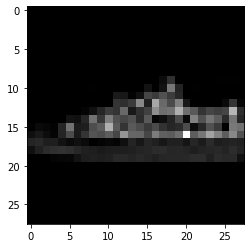

Label: Coat


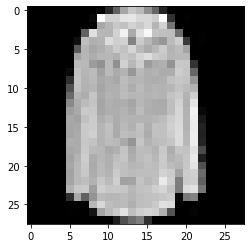

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images
image_index = [42, 789] # "Random" images to print

for index in image_index:
  print( 'Label:', class_names[train_labels[index]])
  plt.figure()
  plt.imshow(np.squeeze(train_images[index], axis=-1))
  plt.gray()
  plt.grid(False)
  plt.show(block=False)

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a strating point. A good modell is expected to have 5-50 times as many parameters!

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),

# Add a hidden Dense layer
Dense(units=16, activation='relu'),

# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')

])

model.summary()

Input shape (28, 28, 1)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 flatten_15 (Flatten)        (None, 12544)             0         
                                                                 
 dense_36 (Dense)            (None, 16)                200720    
                                                                 
 dense_37 (Dense)            (None, 10)                170       
                                                                 
Total params: 201,050
Trainable params: 201,050
Non-trainable params: 0
_________________________________________________________________


# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

# Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size


# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images, to_categorical(val_labels))
)


Epoch 1/15
1500/1500 [==============================] - 28s 13ms/step - loss: 0.9306 - categorical_accuracy: 0.6536 - val_loss: 0.4733 - val_categorical_accuracy: 0.8249
Epoch 2/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6080 - categorical_accuracy: 0.7785 - val_loss: 0.3988 - val_categorical_accuracy: 0.8550
Epoch 3/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.5309 - categorical_accuracy: 0.8071 - val_loss: 0.3552 - val_categorical_accuracy: 0.8761
Epoch 4/15
1500/1500 [==============================] - 19s 12ms/step - loss: 0.4868 - categorical_accuracy: 0.8290 - val_loss: 0.3160 - val_categorical_accuracy: 0.8939
Epoch 5/15
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4481 - categorical_accuracy: 0.8436 - val_loss: 0.3327 - val_categorical_accuracy: 0.8771
Epoch 6/15
1492/1500 [============================>.] - ETA: 0s - loss: 0.4256 - categorical_accuracy: 0.8537

KeyboardInterrupt: ignored

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

In [ ]:
epochrange = range(1, epochs + 1) # change to the epoch it stopped at when adding the early stopping method
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,to_categorical(test_labels))
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.2220 - categorical_accuracy: 0.9221
Test accuracy: 0.922


# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell?
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det?
* Hur många epochs skulle ha varit lämpligt att använda?

Answer:

*   The model has 201,050 parameters. 
*   After training for 15 epochs, the test accuracy is 89% (0.894).
*   In order to analyze whether the model is underfitted or overfitted, there is a validation metrics help indicate the model's fitting. At 7 epochs, the validation loss is at its lowest and rises subsequently up gradually. This indicated that the model is overfitting, training to score better on the training set and not worse of new input values.
*   For this model (absence of regulatization except for the singluar convolution layer), 7 epochs would suffice.


 



# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då? 
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där verifieringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

In [ ]:
# Kod för din bästa modell och dess träning och utvärdering
input_shape = test_images[0].shape
print("Input shape", input_shape)
 
# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([
 
# Add a convolution layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
#Add a pooling layer
tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
# Add a convolution layer
Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
#Add a pooling layer
tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
 
 
# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),
 
# Add a hidden layer
Dense(16, activation="relu"),
 
 
# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')
 
])
 
model.summary()

Input shape (28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (No

# Analys
### More dense layers
I experimented with increasing amount and size of the dense layers to (300, 50, and 10). This resulted in 3,700k parameter. The test accuracy was higher 92% but the test took approx 3m.

I added other convolution layers as well to reduce the need for more dense layers: conv(32) > conv(64) > conv(128) > max (2,2) > dense(128) > dense(softmax). The result was 2,000k parameters with 0.923 accuracy.

As i didn't want to increase the parameters i used other methods to achieve an over 0.9 test accuracy.

### Best result
I experimented with adding 2 convolution layers [kernel size = (3,3)], 2 pooling [pool_size=(2, 2)],  1 flatter and 2 dense layers. This allowed me reduce to approx 30k less parameter compared to the original model at 201k parameter. This model scored 91%(0.911) with only 175k parameters. The started to slightly overfit around the 13th epoch, but considering that the some overfitting is OK, 15 was ideal.

### More convolution
I tried adding a third convolution later with and without an extra pool. The result were nearly the same. I tried removing the pools: the validation loss shot up very quickly, around the 6th epoch. Despite that, the test accuracy was 0.9.

### Differnt kernel size
I added a kernal size smaller then larger convolution layers, in accordance to the cortex's neuron( the first focus on a small local receptive field and the others focus on the larger patterns). This didn't help, but rather dropped the test accuracy to 0.906. 2 convolution layers: the first [kernel size = (2,2)] and the second [kernel size = (3,3)]. Results fluctuated between 0.906-0.910. Even though the less kernel size the less parameters, the scoring was under 0.911 (the best result).

As suggested in the excersize, i added 2 convolution layers: the first [kernel size = (5,5)] and the second [kernel size = (3,3)]. The result was 0.905 after the first epoch but then stagnated, fluctuating between 0.90 to 0.91.

### Differnt amount of filters
I experimented adding different size filters. Inspire by the LeNet-5 described in the book, i added in > conv(6) > pool > conv(16) > pool > conv(160) > flatten > dense(84) > dense(10), but i resulted 0.911 with 9,700k parameter, so a downgrade due to excess parameters. 

The LeNet-5 code verbatium from the book only resulted in an underwhelming 0.833 and 32k parameters.

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [See Geron s. 141]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


In [ ]:
# Compile the model, as a preparation for training
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  callbacks = [es],
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2700 - categorical_accuracy: 0.9016 - val_loss: 0.2595 - val_categorical_accuracy: 0.9103
Epoch 2/15
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2239 - categorical_accuracy: 0.9174 - val_loss: 0.2367 - val_categorical_accuracy: 0.9231
Epoch 3/15
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2028 - categorical_accuracy: 0.9241 - val_loss: 0.2193 - val_categorical_accuracy: 0.9197
Epoch 4/15
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1789 - categorical_accuracy: 0.9329 - val_loss: 0.2168 - val_categorical_accuracy: 0.9231
Epoch 5/15
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1656 - categorical_accuracy: 0.9373 - val_loss: 0.2175 - val_categorical_accuracy: 0.9218
Epoch 6/15
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1480 - categorical_accuracy: 0.9434 - val_loss: 0.2131 - val_categorical_acc

## Analys
Vid vilken Epoch stannar nu träningen? Ändras nu modellens testnoggrannhet då den inte övertränar?

with patient set to 5

The model given to us averages a lower test accuracy of 0.888 compared to 0.894 when trained without early stopping. 

My model in subpart 1b has now, trained with early stopping, a more stable test accuracy at 0.912 instead of averaging sometimes 0.908. It stops at epoch 9 (3 epochs after the first increase in val_loss) 

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [See Geron s 338, s. 365]

In [ ]:
# Kod där du inför regularisering
input_shape = test_images[0].shape
print("Input shape", input_shape)
 
# The Keras model will be the simplest Keras model for NN networks.
# It is a single stack of layers connected sequentially.
model = Sequential([

# Add a convolution layer
Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
# Add a convolution layer
Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
#Add a pooling layer
tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
# Dropout
tf.keras.layers.Dropout(0.5),
 
# Add a convolution layer
Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
#Add a pooling layer
tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
# Dropout
tf.keras.layers.Dropout(0.5),
 
# Flatten the input. This prepares the vector for fully connected layers.
Flatten(),
# Add a hidden layer
Dense(128, activation='relu'),
 
# Add a an output layer. The output space is the number of classes
#    Softmax makes the output as probablity vector of the different classes
Dense(units=num_classes, activation='softmax')
])
model.summary()

Input shape (28, 28, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 27, 27, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 27, 27, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                          

## Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? 

### 3 layers of dropout
With dropout, I added 2 new dense layers and increased their size greatly to compensate for the dropout: ened up with 200k parameter. The dense layers' size was 500, 300, 10 respectively.  the training accuracy/loss and validation accuracy/loss has a strong correlate: nearly same accuracy. The Without regularization, the accuracy tends to increase roughly 10% higher than validation accuracy. However, The test accuracy is averaging a measly 0.814 accurcay and trained 15 epochs.

### 3 dense layers, 2 dropout
I tried to decrease the amount regularization because the accuracy was stagnating at 7 epochs and stopped training at 8 epochs. this achieve the same accuracy with only 52k parameters as also decrease the size of the dense layers to 300, 100, and 10 respectively and dropout rate (0.2). The test accuracy was 0.800.

### 6 convolution layers with batch normalization
My highest yet test accuracy at 0.924 after 11 epochs and yet, kept my model to only 400k parameters.. The convoluation layer filters started with two layers with 32 filter, two layers with 64 filters, and two layers 128 filters, the three pares divided by a pooling layer. I added dense layers of sizes in the following order: 100, 50 and softmax. (This is my best model so far)

### 3 convolution layers with dropout (found online)
The model had 2 convolution layers > pooling > dropped (0.5). Followed by 1 convolution layer > max pooling > dropped(0.5). Finally, 2 dense layers: 128 and softmax respectively. I was able to attain the same result of 0.924 (compared to aformentioned model) in 13 epochs but with less convolution layers, so this is my best model and will be used as a base for further testing.

### Overboard
I thought i would just increase the layers to reach the point: "alright, this has gone overboard". 6 convolution layers, each followed by batch noramlization, and 3 dense layers. The validation accuracy dipped super low getting somewhere between 0.2 and 0.4. I added L2 regularization to my convolution and dense layers but the validation result was still so low.






# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [See Geron s. 325.., s. 351.. ]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från adam till sgd (med regularisering och avbruten träning). Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?). 

### Answer

I read online that sgd is better for image recognition, but this wasn't reflected it from my results. However, this could be due to me adjusting my model to best suited for Adam optimized.

Sgd opitimized training had the following attribute: 0.906 test accuracy, stopped at 14 epochs, and val_loss began at 0.4 but dropped and stagnated at 0.23.

Adam opitimized training had the following attribute: 0.924 test accuracy, stopped at 10 epochs, and val_loss began at 0.2s and stagnated. The result was val_acc stagnant, fluctuating between 0.921 and 0.935

In [ ]:
# Din kod för en körning med sgd som optimerare
# Compile the model, as a preparation for training
model.compile(
  optimizer='sgd',
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy']
)

epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

# Train the model.
history = model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  callbacks = [es],
  validation_data=(val_images, to_categorical(val_labels))
)

Epoch 1/15
1500/1500 [==============================] - 14s 8ms/step - loss: 0.6451 - categorical_accuracy: 0.7621 - val_loss: 0.4516 - val_categorical_accuracy: 0.8541
Epoch 2/15
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4106 - categorical_accuracy: 0.8510 - val_loss: 0.3671 - val_categorical_accuracy: 0.8802
Epoch 3/15
1500/1500 [==============================] - 14s 9ms/step - loss: 0.3576 - categorical_accuracy: 0.8709 - val_loss: 0.3600 - val_categorical_accuracy: 0.8860
Epoch 4/15
1500/1500 [==============================] - 13s 8ms/step - loss: 0.3296 - categorical_accuracy: 0.8803 - val_loss: 0.3243 - val_categorical_accuracy: 0.8871
Epoch 5/15
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3063 - categorical_accuracy: 0.8891 - val_loss: 0.2958 - val_categorical_accuracy: 0.8978
Epoch 6/15
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2883 - categorical_accuracy: 0.8940 - val_loss: 0.2783 - val_categorical_acc

KeyboardInterrupt: ignored

# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab)
import os


!pip install keras-tuner -q;

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 40.7 MB/s 
Keras Tuner version: 1.1.3


## Exempelmodell (du ska sedan göra en egen!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5, 
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):  
  model = tf.keras.Sequential([
    # First Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    tf.keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 1 och instrumentera den för att optimeras med Keras Tuner.

In [ ]:
input_shape = test_images[0].shape

# Kompletera denna kod med din modell
def build_model_MyModelOne(hp):  
  model = tf.keras.Sequential([
      # Add a convolution layer
      tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
      # Add a convolution layer
      tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
      #Add a pooling layer
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
      # Dropout
      tf.keras.layers.Dropout(0.5),
      
      
      # Add a convolution layer
      tf.keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
      #Add a pooling layer
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
      # Dropout
      tf.keras.layers.Dropout(0.5),
      
      # Flatten the input. This prepares the vector for fully connected layers.
      Flatten(),
      # Add a hidden layer
      tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
            activation='relu'
      ),

      # A Final Dense Layer
      tf.keras.layers.Dense(10, activation='softmax')
    ])
  
  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization. 

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_MyModelTwo, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

JAg körde


# Help it takes so much time!
Yes, doing a parameter search takes time! Using a K80 this search takes 1h24 (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels, 
             epochs=noepochauto, 
             validation_data=(val_images, val_labels), 
             callbacks=[es])

Trial 20 Complete [00h 02m 44s]
val_accuracy: 0.9268749952316284

Best val_accuracy So Far: 0.9301249980926514
Total elapsed time: 00h 39m 20s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
#for keys,values in vals.items():
   # print('%20s = %3.4g' %(keys,values))
    
model.summary()

JAg körde
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 112)       16240     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 112)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 112)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 112)       113008    
                                                                 
 average_pooling2d (AverageP  (None, 22, 22, 112)      0         
 ooling2D)                                    

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.2165 - accuracy: 0.9253
Test accuracy: 0.925


## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   conv_3_filter   conv_3_kernel   dense_1_units   learning_rate      batch_size 

          0.928              64               3             256               5             128               3             192           0.001             288 
          0.923             256               3             224               5             128               5              96           0.001             192 
          0.921             192               3             160               5              32               3             224           0.001              32 
          0.923              64               3             224               5             192               5             160           0.001              64 
          0.921             160               5             224               5             128               5             160           0.001             256 


Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation. 

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

JAg körde
Epoch 1/30
250/250 [==============================] - 14s 53ms/step - loss: 0.0997 - accuracy: 0.9625 - val_loss: 0.1979 - val_accuracy: 0.9326
Epoch 2/30
250/250 [==============================] - 13s 52ms/step - loss: 0.0757 - accuracy: 0.9730 - val_loss: 0.2309 - val_accuracy: 0.9302
Epoch 3/30
250/250 [==============================] - 12s 49ms/step - loss: 0.0569 - accuracy: 0.9789 - val_loss: 0.2440 - val_accuracy: 0.9286
Epoch 3: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.2222 - accuracy: 0.9278
Test accuracy: 0.928


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 160)       256160    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 160)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 31360)             0         
                                                                 
 dense (Dense)               (None, 256)               8

#Analys

### frågorna
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden då fått fram i del 1 och del 2? 
* Vilka prestanda fick du för de olika fallen? 
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsefulla? 
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? 
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?

## Answers

The model generated from bayesian searching had many more parameters: 17,300k compared to 5,600k. This is manly due a dense layer of kernel size 192 compared to 128. 

The kernel sizes of all there convolution laters were are (5,5) compared to my (3,3) in part Additionly, the filter size of the second convolution layer (out of 3) is 256 and the third convolution later is 128, compared to 64. 

The preformance improved a fair amount, landing at 0.928 compared to 0.924.

If i would run again the test, i would increase the choice of kernel size for the convolution layers to 3, 5 and 7. This is mainly due to better preformance was always recorded when the second convolution layer had a kernel size of (5,5). As mentioned before, i based (at least attempt to) my model on the the neuron structure of the coretex. so this wasn't a suprised as i already had the second convolution layer kernel size set to (5,5). However, what happens when try larger kernel size would be interesting.

The mode usefull parameters seemed to be the comboination of the thirs convolution layers. 

The trend that i can spot is the convolution layer 1 and 2's relationship. Otherwise the other hyperparameters seem to be somewhat random combinations.

The result may vary as the training process is random and an execution per trail can be a way to offset luck in case we got a good model but an unlucky fitting(training session).


The one major thing i notice is how high density tends to dominate bayesian seaches. It doesn't take into consideration the training time and just focuses on which model has thhe highest accuracy. When i manually did the search i tried to adjust to only 170k parameters in my first model in 1b so i would keep the training time short. This is somewhat mitigated by the ability to adjust the bounds of hyperparameters and "explore the n best models"

# Uppgifter för väl godkänt

##Utökning av Del2:
Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

375/375 [==============================] - 1s 3ms/step


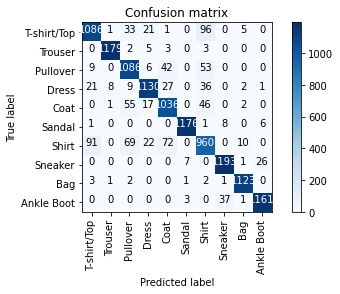

In [ ]:
##plotting the confusion matrix (copied from kaggle)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset and convert to one hot vectors 
Y_pred = np.argmax(model.predict(val_images), axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(val_labels, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, Y_pred, target_names = class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.87      0.89      1243
     Trouser       0.99      0.99      0.99      1192
    Pullover       0.86      0.91      0.89      1196
       Dress       0.94      0.92      0.93      1234
        Coat       0.88      0.90      0.89      1157
      Sandal       0.99      0.99      0.99      1192
       Shirt       0.80      0.78      0.79      1224
     Sneaker       0.96      0.97      0.97      1227
         Bag       0.98      0.99      0.99      1133
  Ankle boot       0.97      0.97      0.97      1202

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



### Answer
Accoridng to the confusion matrix, shirts are often confused with t-shirts/tops. Confusion according to the classification rapport percision seems to be lowest amongst similar looking classes: t-shirts, pullover, coat and shirts. however, this isnt a problem to amongs sneakers and ankle boots and thats probabilt because on the larger field, the patterns are easier to distiguish. 

Thus, we can conclude that the small receptive fields are needed to better distinguish the finer details that goes into distinguishing between these similar looking classes.

###Utökning av Del3:
Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

Tips: Det är nog bäst att använda en inkrementell/funktionell definition av modellen (där lager läggs till med "model.add(...)" för då blir det lättare att göra en for-slinga runt koden som lägger till ett visst antal lager. Jmf https://keras.io/guides/sequential_model/ 


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....) 
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...), 
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



In [ ]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter 
# och där du söker efter optimerade hyperparametrar för denna modell.

input_shape = (28,28,1)

def build_model_MyModelTwo(hp):  

  model = Sequential()
  # Add a first convolution layer (with input size)
  model.add(Conv2D(filters= 16, kernel_size = (3,3) , padding='same', activation='relu', input_shape=(28,28,1)))

  # Add a varying number of layers
  for i in range(1, hp.Int("num_layers 1", 1, 2)):
    model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', min_value=16, max_value=128, step=32, default=64), 
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5], default=3),
                    activation='relu',
                    input_shape = (28,28,1)
                    ))
                
  #Add a pooling layer
  if hp.Choice('pooling_1', ['avg', 'max']) == 'max':
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
  else:
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

  # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
  model.add(tf.keras.layers.Dropout(hp.Float(f"dropout_perm1", 0, 0.5, step=0.1)))

  # Add a varying number of layers
  for i in range(1, hp.Int("num_layers 2", 1, 2)):
    model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', min_value=16, max_value=128, step=32, default=64), 
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5], default=3),
                    activation='relu',
                    input_shape = (28,28,1)
                    ))
  #Add a pooling layer
  if hp.Choice('pooling_2', ['avg', 'max']) == 'max':
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
  else:
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

  #Add a flatten
  model.add(tf.keras.layers.Flatten())

  # Tune the number of hidden layers and units in each.
  # Number of hidden layers: 1 - 2
  # Number of Units: 32 - 512 with stepsize of 32
  for i in range(1, hp.Int("num_layers 3", 1, 2)):
    model.add(
        tf.keras.layers.Dense(
            units=hp.Int(f"units_{i+1}", min_value=16, max_value=512, step=32),
            activation="relu"))

  # A Final Dense Layer
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  print("JAg körde")

  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model


##Analys

My first trail will be be to change the kernel sizes. I would like to recall my analysis from 1b:

> "I added a kernal size smaller then larger convolution layers, in accordance to the cortex's neuron( the first focus on a small local receptive field and the others focus on the larger patterns)."

I will start with the model in 3. The best model i was able to achieve was 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
    

*    conv2d (Conv2D)             (None, 28, 28, 16)        160   
*   conv2d_1 (Conv2D)           (None, 26, 26, 112)       16240 

* max_pooling2d (MaxPooling2D  (None, 25, 25, 112)      0                                                                      
                                                                 
* dropout (Dropout)           (None, 25, 25, 112)       0         
                                                                 
* conv2d_2 (Conv2D)           (None, 23, 23, 112)       113008    
                                                                 
* average_pooling2d (AverageP  (None, 22, 22, 112)      0         
 ooling2D)                                                       
                                                                 
* flatten (Flatten)           (None, 54208)             0         
                                                                 
* dense (Dense)               (None, 496)               26887664  
                                                                 
* dense_1 (Dense)             (None, 10)                4970      
                                                                 

Total params: 27,022,042

Trainable params: 27,022,042

Non-trainable params: 0
_________________________________________________________________

Test accuracy: 0.931


Session timed out before running the code for the n best and saving other information about the hyperparameters such as kernel size and dropout rate.
